In [24]:
import pandas as pd
import numpy as np
import pyvista as pv
pv.global_theme.jupyter_backend = 'static'

import sys
import os
# Add the parent directory to the system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

Get data and create giant df fo all drone trajs

In [25]:
exp_dir = f'Best_agent_res_gen_2 exp 32'
trained_scen = "advanced"
model_name = "test_agent_model_10000"

df1 = pd.DataFrame()
test_scenarios = ['cave', 'deadend', 'helix', 'horizontal', 'house_easy', 'house_easy_obstacles', 'house_hard', 'house_hard_obstacles', 'vertical']

for test_scen in test_scenarios:
    retrieve_data_path = os.path.join(parent_dir, 'log', 'LV_VAE_MESH-v0', exp_dir , trained_scen, 'results_gen', test_scen, model_name)
    metrics_data = pd.read_csv(retrieve_data_path + '/test_summary.csv')
    metrics_data['test_scen'] = test_scen
    df1 = pd.concat([df1, metrics_data])


In [26]:
exp_dir = f'Best_agent_res_gen_1 exp 10005'
trained_scen = "proficient_perturbed"
model_name = "test_agent_model_180000"

df2 = pd.DataFrame()
test_scenarios = ['cave', 'deadend', 'helix', 'horizontal', 'house_easy', 'house_easy_obstacles', 'house_hard', 'house_hard_obstacles', 'vertical']

for test_scen in test_scenarios:
    retrieve_data_path = os.path.join(parent_dir, 'log', 'LV_VAE_MESH-v0', exp_dir , trained_scen, 'results_gen', test_scen, model_name)
    metrics_data2 = pd.read_csv(retrieve_data_path + '/test_summary.csv')
    metrics_data2['test_scen'] = test_scen
    df2 = pd.concat([df2, metrics_data2])

In [27]:
print(df1['test_scen'].unique())
print(df1.columns)

print(df2['test_scen'].unique())
print(df2.columns)

['cave' 'deadend' 'helix' 'horizontal' 'house_easy' 'house_easy_obstacles'
 'house_hard' 'house_hard_obstacles' 'vertical']
Index(['Episode', 'Timesteps', 'Avg Absolute Path Error', 'Speed', 'IAE Cross',
       'IAE Vertical', 'Progression', 'Success', 'Collision', 'Avg Speed',
       'test_scen'],
      dtype='object')
['cave' 'deadend' 'helix' 'horizontal' 'house_easy' 'house_easy_obstacles'
 'house_hard' 'house_hard_obstacles' 'vertical']
Index(['Episode', 'Timesteps', 'Avg Absolute Path Error', 'Speed', 'IAE Cross',
       'IAE Vertical', 'Progression', 'Success', 'Collision', 'Avg Speed',
       'test_scen'],
      dtype='object')


Calculate the means and confidence intervals for each metric to be plotted in the spiderweb

In [35]:
metrics = ['Avg Absolute Path Error', 'Avg Speed', 'Progression', 'Success', 'Collision']
labels = ['Avg. path deviation', 'Avg. speed', 'Path progression', 'Success rate', 'Collision rate']

# For the given metrics, calculate the mean and 95% confidence interval across all rows of df
def calculate_mean_ci(df, metrics):
    mean = df[metrics].mean()
    std = df[metrics].std()
    ci = df[metrics].std() * 1.96 / np.sqrt(df[metrics].count())
    return mean, std, ci

mean1, std1, ci1 = calculate_mean_ci(df1, metrics)
mean2, std2, ci2 = calculate_mean_ci(df2, metrics)
# print('Means 1:')
# print(mean1)
# print('Confidence intervals 1:')
# print(ci1)

# print('Means 2:')
# print(mean2)
# print('Confidence intervals 2:')
# print(ci2)


# PRINT THE RESULTS LIKE: METRIC MEAN, [MEAN - CI, MEAN + CI] FOR BOTH
for i, metric in enumerate(metrics):
    print(f'Random {metric}: {mean1[metric]:.5f} [{mean1[metric] - ci1[metric]:.5f}, {mean1[metric] + ci1[metric]:.5f}] {std1[metric]:.5f}')
    print(f'Locked conv {metric}: {mean2[metric]:.5f} [{mean2[metric] - ci2[metric]:.5f}, {mean2[metric] + ci2[metric]:.5f}] {std2[metric]:.5f}')


Random Avg Absolute Path Error: 1.15638 [1.06543, 1.24733] 1.41743
Locked conv Avg Absolute Path Error: 0.66857 [0.62288, 0.71425] 0.69928
Random Avg Speed: 0.96458 [0.95289, 0.97628] 0.18227
Locked conv Avg Speed: 0.95317 [0.94218, 0.96416] 0.16815
Random Progression: 0.73108 [0.71212, 0.75004] 0.29552
Locked conv Progression: 0.70988 [0.68993, 0.72983] 0.30540
Random Success: 0.49303 [0.46094, 0.52513] 0.50022
Locked conv Success: 0.48778 [0.45510, 0.52045] 0.50013
Random Collision: 0.48767 [0.45558, 0.51977] 0.50012
Locked conv Collision: 0.50778 [0.47510, 0.54046] 0.50022


create spider web plot

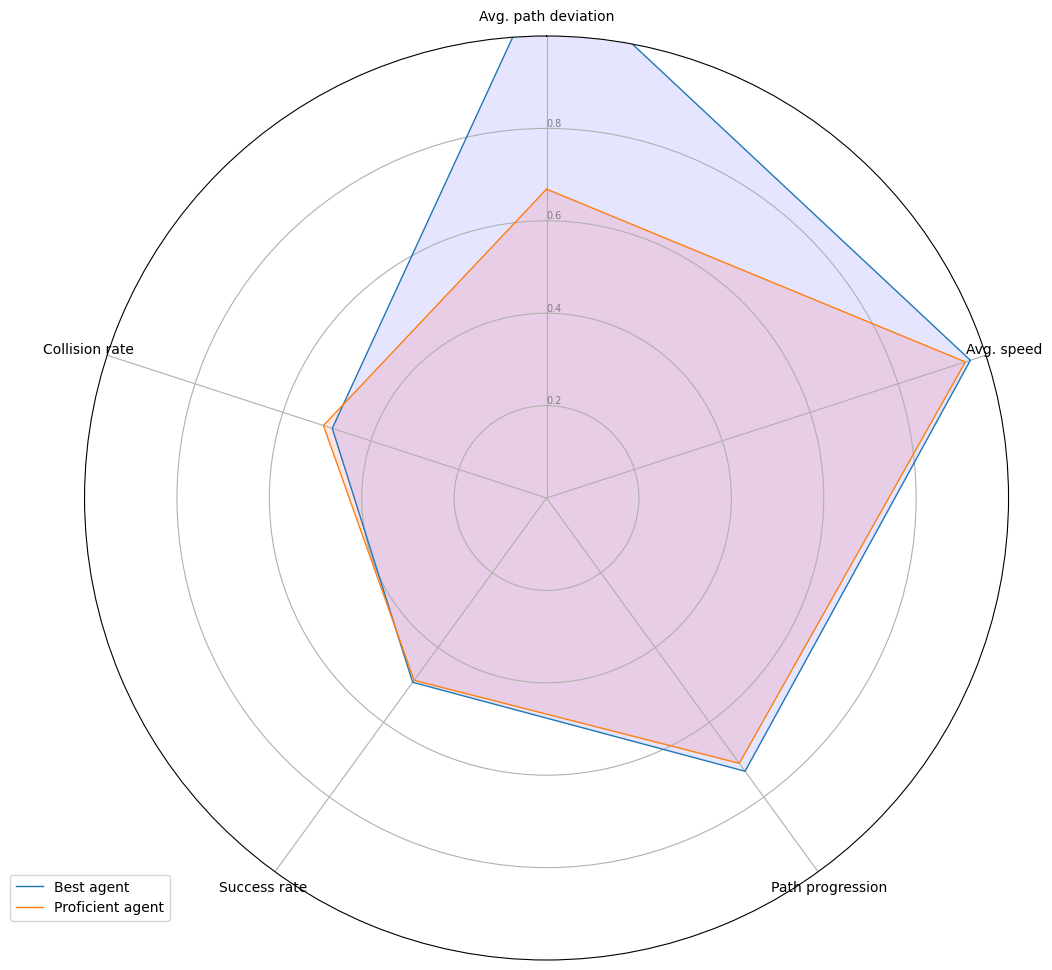

In [30]:
# Create a spider web plot with the two sets of data overlapping with means and cis as defined above
import matplotlib.pyplot as plt

def plot_spider_web(mean1, ci1, mean2, ci2, metrics, labels):
    N = len(metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'polar': True})
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], labels)

    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)

    values1 = mean1.tolist()
    values1 += values1[:1]
    values2 = mean2.tolist()
    values2 += values2[:1]

    ax.plot(angles, values1, linewidth=1, linestyle='solid', label='Best agent')
    ax.fill(angles, values1, 'b', alpha=0.1)

    ax.plot(angles, values2, linewidth=1, linestyle='solid', label='Proficient agent')
    ax.fill(angles, values2, 'r', alpha=0.1)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

plot_spider_web(mean1, ci1, mean2, ci2, metrics, labels)
